Checking if there is a GPU device available for training. I did the training on Kaggle, so this is just to debug.

In [12]:
!pip install d2l

In [13]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
Device Name: Tesla T4


In [14]:
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from d2l import torch as d2l
import os
import pandas as pd

## Below I define:
- A custom Test Dataset class to make the test dataloader
- The network architecture (to be changed and modified further)
- A custom Data class to be passed into the trainer.fit() method later

In [81]:
class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname)
            for fname in os.listdir(root)
            if fname.endswith(('jpg', 'png', 'jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

def init_cnn(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.LazyConv2d) or isinstance(module, nn.LazyLinear):
        nn.init.xavier_uniform_(module.weight)

class NandNet(d2l.Classifier):
    def __init__(self, numchannels, lr=0.1, num_classes=2):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(16, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(9, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(9, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(), nn.LazyLinear(256), nn.LazyBatchNorm1d(),
            nn.ReLU(), nn.LazyLinear(64), nn.LazyBatchNorm1d(),
            nn.ReLU(), nn.LazyLinear(num_classes), nn.Softmax()
        )
        
        self.best_loss = float('inf')
        self.best_acc = 0
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        a = self.accuracy(Y_hat, batch[-1])
        if l < self.best_loss:
            self.best_loss = l
        if a > self.best_acc:
            self.best_acc = a
        self.plot('loss', l, train=False)
        self.plot('acc', a, train=False)

        

class MyData(d2l.DataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train = trainset
        self.val = valset
        self.batch_size = batch_size
        

    def text_labels(self, indices):
        labels = ["yes", "no"]
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return DataLoader(data, self.batch_size, shuffle=train, num_workers=4)

    def visualize(self, batch, nrows=1, ncols=8, labels=None):
        if labels is None:
            labels = []
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

## Below I define:
- The transformations to apply to our data in order to augment it
- The variables that hold the training, validation, and test sets

In [82]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.85, 1.15),
        ratio=(0.75, 1.33)
    ),
    transforms.ToTensor(),
])

kaggle = True

data_path = '/kaggle/input/kagglechallengedata/dl2425_challenge_dataset' if kaggle else 'dl2425_challenge_dataset'

trainset = datasets.ImageFolder(
    root = data_path + '/train',
    transform = transform
)
valset = datasets.ImageFolder(
    root = data_path + '/val',
    transform = transform
)
testset = TestDataset(
    root = data_path + '/test',
    transform = transform
)

testloader = DataLoader(testset, batch_size=64, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NandNet(numchannels=12, lr=0.01, num_classes=2)
#model.layer_summary((64, 3, 224, 224))
model = model.to(device)
trainer = d2l.Trainer(max_epochs=15, num_gpus=4)
dummy_input = torch.randn(64, 3, 224, 224).to(device)
model(dummy_input)
model.apply(init_cnn)
data = MyData(batch_size=64)

## Below I define:
- The code to train the model
- (If ran in a Jupyter Notebook cell, it also outputs a dynamic train-acc graph)

tensor(0.3266, device='cuda:0') tensor(1., device='cuda:0')


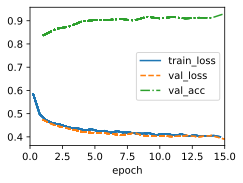

In [83]:
if __name__ == '__main__':
    
    trainer.fit(model, data)
    print(model.best_loss, model.best_acc)
    torch.save(model.state_dict(), '4l_var-chnl_256-64_maxpool2_tinylr.pth')

## Below I define:
- The model that is to be loaded from the models directory
- The test loop
- The results Data Frame which takes multiple dictionaries in the form {id: class} and converts them into cells in a .csv file
- Saves the predictions.csv file to desired path (this is what we will submit)

In [ ]:
device = torch.device("cuda")
model = NandNet(numchannels=9, lr=0.1, num_classes=2)
current_model = 'models/model_weights_4layers_9channels.pth'
model.load_state_dict(torch.load(current_model))
model = model.to(device)
model.eval()

results = []

with torch.no_grad():
    for images, paths in testloader:
        images = images.to(device)
        outputs = model(images)
        
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1) 

        for path, pred in zip(paths, predictions.cpu().numpy()):
            filename = os.path.basename(path) 
            results.append({"id": filename, "class": int(pred)})

# save model predictions!!
results = sorted(results, key = lambda x: int(x["id"].replace(".jpg", "")))
df = pd.DataFrame(results)
df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

## Next steps:
- Make the model better
- Utilize as few pre made d2l methods as possible
- Once we are confident in our prediction results, merge (labeled) test, train, and val
- Train the final model on all of it